Transfter Learning with Keras : https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/


BERT IMDB: https://www.kaggle.com/atulanandjha/bert-testing-on-imdb-dataset-extensive-tutorial

In [1]:
from keras.applications.vgg16 import VGG16

In [2]:
model = VGG16()

model.summary()

2022-03-11 15:07:08.734740: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


553476096/553467096 [==============================] - 245s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

In [4]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

image = load_img('./data/dog.jpeg', target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
yhat = model.predict(image)
label = decode_predictions(yhat)
label = label[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))

49152/35363 [=========================================] - 0s 1us/step
Doberman (35.42%)


In [7]:
from keras.models import Model
from pickle import dump

image = load_img('./data/dog.jpeg', target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
features = model.predict(image)
print(features.shape)
dump(features, open('dog.pkl', 'wb'))

(1, 4096)


In [8]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten


model = VGG16(include_top=False, input_shape=(300, 300, 3))
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)


model.summary()

58900480/58889256 [==============================] - 25s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                           

## BERT + IMDB Transfer Learning

In [12]:
import sys
import numpy as np
import random as rn
import pandas as pd
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

In [16]:
train_data = pd.read_csv("./data/imdb-50k-train.csv")
test_data = pd.read_csv("./data/imdb-50k-test.csv")

In [17]:
train_data = train_data[:2000]
test_data = test_data[:500]

train_data = train_data.to_dict(orient='records')
test_data = test_data.to_dict(orient='records')
type(train_data)

list

In [18]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(2000, 2000, 500, 500)

In [19]:
train_texts[0]

"Now, I won't deny that when I purchased this off eBay, I had high expectations. This was an incredible out-of-print work from the master of comedy that I so enjoy. However, I was soon to be disappointed. Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch. I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler. You could tell that this was not Al's greatest video achievement (that honor goes to UHF). Honestly, I doubt if this will ever make the jump to DVD, so if you're an ultra-hardcore Al fan and just HAVE to own everything, buy the tape off eBay. Just don't pay too much for it."

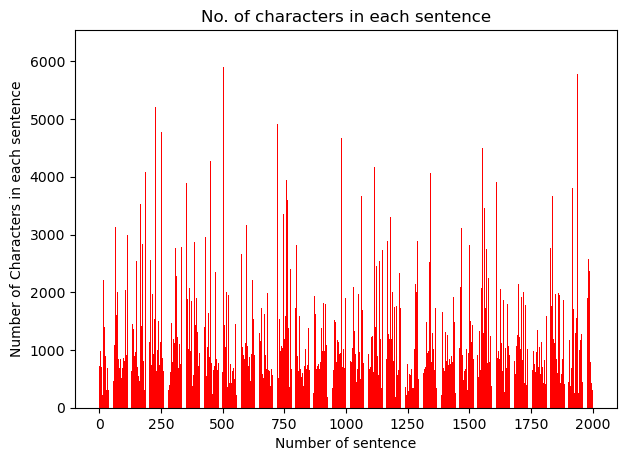

In [20]:
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,2001), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|████████████████████████████████| 231508/231508 [00:01<00:00, 230522.28B/s]


In [22]:
tokenizer.tokenize('Hi my name is Pranav')

['hi', 'my', 'name', 'is', 'pr', '##ana', '##v']

In [23]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(2000, 500)

In [24]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((2000, 512), (500, 512))

In [25]:
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((2000,), (500,), 0.4855, 0.508)

In [26]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [28]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/Users/pranav/learning_plan/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
baseline_predicted = baseline_model.predict(test_texts)

In [30]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

         neg       0.82      0.84      0.83       246
         pos       0.84      0.83      0.83       254

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



In [31]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [33]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [34]:
bert_clf = BertBinaryClassifier()

100%|██████████████████████████| 407873900/407873900 [07:08<00:00, 951169.68B/s]


In [37]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [38]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)
x.shape, y.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 512, 768]), torch.Size([3, 768]))

In [39]:
y = bert_clf(x)

In [40]:
y.cpu().detach().numpy() 

array([[0.43306476],
       [0.5052953 ],
       [0.4124697 ]], dtype=float32)

In [41]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [42]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [43]:
BATCH_SIZE = 4
EPOCHS = 10

In [44]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [45]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [46]:
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]


In [47]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [49]:
torch.cuda.empty_cache() 

### This was taking a lot of time (so pls refer the notebook from kaggle for the outputs)

In [50]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))

Epoch:  1
10/500.0 loss: 0.6999479369683699 
0.0M


KeyboardInterrupt: 

In [ ]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
np.mean(bert_predicted)

In [ ]:
print(classification_report(test_y, bert_predicted))